In [1]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [3]:
def calculate_community_quality(G, community):
    """Calculates quality metrics for a given community structure in a graph.

    This function computes three common metrics to assess the quality of a
    community partition in a graph: modularity, coverage, and performance.

    Modularity measures the strength of division of a network into communities.
    It quantifies the difference between the fraction of edges within communities
    and the expected fraction if edges were distributed at random. Higher
    modularity values (closer to 1) generally indicate better community structure.

    Coverage is the fraction of edges that fall within communities. It measures
    how much of the network's connectivity is captured by the identified
    communities. Higher coverage is generally desirable.

    Performance is a metric that combines coverage and the fraction of vertices
    in communities. It is designed to be less sensitive to the number of
    communities and the size of the graph than coverage alone. Higher performance
    values are generally better.

    Args:
        G (nx.Graph): The NetworkX graph for which to calculate community quality.
        community (list of set): A list of sets, where each set represents a
            community and contains the nodes belonging to that community.
            For example: `[{1, 2, 3}, {4, 5}]` represents two communities.

    Returns:
        dict: A dictionary containing the calculated community quality metrics.
              The dictionary has the following keys:
                - 'modularity' (float): The modularity score of the community structure.
                - 'coverage' (float): The coverage score of the community structure.
                - 'performance' (float): The performance score of the community structure.

    Examples:
        >>> import networkx as nx
        >>> G = nx.karate_club_graph()
        >>> community = [{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21}, {9, 14, 15, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}]
        >>> quality_metrics = calculate_community_quality(G, community)
        >>> print(quality_metrics)
        {'modularity': 0.3792373075876584, 'coverage': 0.77875, 'performance': 0.6007444168734458}
    """
    modularity = nx.community.modularity(G, community)
    community_quality_result = nx.community.partition_quality(G, community)
    return {
        'modularity': modularity,
        'coverage': community_quality_result[0],
        'performance': community_quality_result[1],
    }

def analyze_community_sizes(communities):
    """
    Analyze community sizes when communities are provided as a list of sets
    """
    # Calculate size of each community
    sizes = [len(community) for community in communities]
    
    return {
        'total_communities': len(communities),
        'largest_community': max(sizes),
        'smallest_community': min(sizes),
        'average_size': np.mean(sizes),
        'median_size': np.median(sizes),
        'size_distribution': sizes
    }

def visualize_community_sample(G, communities, method_name, max_nodes=500):
    """
    Visualize sample of largest and medium communities with directed edges and nodes colored by group
    communities: list of sets where each set contains nodes of one community
    """
    # Sort communities by size (largest first)
    sorted_communities = sorted(communities, key=len, reverse=True)
    
    # Get top 3 largest communities
    largest_communities = sorted_communities[:3]
    
    # Get 3 communities from the middle
    middle_idx = len(sorted_communities) // 2
    middle_communities = sorted_communities[middle_idx-1:middle_idx+2]
    
    # Define color mapping for different product groups
    group_colors = {
        'Book': 'royalblue',
        'Music': 'limegreen',
        'DVD': 'crimson',
        'Video': 'gold',
        'Software': 'purple',
        'CE': 'orange',
        'Baby Product': 'pink',
        'Toy': 'cyan',
        'Video Games': 'darkgreen'
    }
    # Default color for unknown groups
    default_color = 'lightgray'
    
    plt.figure(figsize=(18, 10))
    
    # Function to draw a single community subplot
    def draw_community(community, subplot_idx, label):
        plt.subplot(2, 3, subplot_idx)
        
        # Get nodes in this community
        nodes = list(community)
        
        # If too many nodes, sample them
        if len(nodes) > max_nodes:
            nodes = np.random.choice(nodes, max_nodes, replace=False)
        
        # Create subgraph
        subgraph = G.subgraph(nodes)
        pos = nx.spring_layout(subgraph, seed=42)
        
        # Get node colors based on group attribute
        node_colors = []
        for node in subgraph.nodes():
            try:
                # Try to get group attribute, use default color if not found
                group = G.nodes[node].get('group', None)
                node_colors.append(group_colors.get(group, default_color))
            except:
                node_colors.append(default_color)
        
        # Draw nodes with group colors
        nx.draw_networkx_nodes(subgraph, pos, node_size=30, node_color=node_colors)
        
        # Draw directed edges with arrows
        nx.draw_networkx_edges(subgraph, pos, alpha=0.4, width=0.5, 
                              arrows=True, arrowsize=10, arrowstyle='->')
        
        comm_id = list(communities).index(community)
        plt.title(f"{method_name} - {label} Community {comm_id} (n={len(community)})")
        plt.axis('off')
        
        # Add legend for group colors
        unique_groups = set()
        for node in subgraph.nodes():
            try:
                group = G.nodes[node].get('group', None)
                if group:
                    unique_groups.add(group)
            except:
                pass
        
        # Create legend with only groups present in this community
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                           markerfacecolor=group_colors.get(group, default_color), 
                           label=group, markersize=8)
                           for group in unique_groups]
        
        if legend_elements:
            plt.legend(handles=legend_elements, loc='upper right', fontsize='x-small')
    
    # Draw top 3 communities
    for i, community in enumerate(largest_communities):
        draw_community(community, i+1, "Largest")
    
    # Draw middle 3 communities
    for i, community in enumerate(middle_communities):
        draw_community(community, i+4, "Medium")
    
    plt.tight_layout()
    plt.show()

In [4]:
df_products = pd.read_csv('products_cleaned_engineered.csv')
df_copurchases = pd.read_csv('copurchase_cleaned.csv')

pickle_file_path = 'amazon_copurchase_graph.pickle'
with open(pickle_file_path, 'rb') as f:
    G = pickle.load(f)
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

SEED = 28

Loaded graph with 259102 nodes and 1207337 edges


In [6]:
louvain_communities = nx.community.louvain_communities(G, seed=SEED)
louvain_partition = nx.community.louvain_partitions(G, seed=SEED)
print(f"Found {len(louvain_communities)} communities using Louvain")

# with open('louvain_communities.pickle', 'wb') as f:
#     pickle.dump(louvain_communities, f)

Found 218 communities using Louvain


In [89]:
lpa_communities_generator = nx.community.fast_label_propagation_communities(G, seed=SEED)
lpa_communities = list(lpa_communities_generator)
print(f"Found {len(lpa_communities)} communities using LPA")

with open('lpa_communities.pickle', 'wb') as f:
    pickle.dump(lpa_communities, f)

Found 32680 communities using LPA


In [4]:
# NOTE: Potential for hyperparameter tuning. Params to be tuned:
# - Resolution parameter (resolution=1.0). Try to lower this for larger community (should do it since our graph is very large)
# - best_n (default = None)
# - Curoff (default = 1)
greedy_modularity = nx.community.greedy_modularity_communities(G)
print(f"Found {len(greedy_modularity)} communities using Greedy Modularity")

with open('greedy_modularity.pickle', 'wb') as f:
    pickle.dump(greedy_modularity, f)

Found 1168 communities using Greedy Modularity


In [ ]:
# On the documentation, it says that it should only work for undirected graph (On the source code it turns the graph into undirected first)
# Took way too long, more than 8 hours

girvan_newman_generator = nx.community.girvan_newman(G)
girvan_newman = list(girvan_newman_generator)
print(f"Found {len(girvan_newman)} communities using Girvan-Newman")

with open('girvan_newman.pickle', 'wb') as f:
    pickle.dump(girvan_newman, f)

In [97]:
calculate_community_quality(G, louvain_communities)

{'modularity': 0.9157204820646558,
 'community_quality': (0.9335877224006222, 0.9822948011156766)}

In [103]:
analyze_community_sizes(louvain_communities)

{'total_communities': 218,
 'largest_community': 15988,
 'smallest_community': 2,
 'average_size': 1188.5412844036698,
 'median_size': 395.0,
 'size_distribution': [3396,
  115,
  2302,
  3407,
  2216,
  305,
  3738,
  1804,
  5068,
  2181,
  1201,
  7,
  947,
  15,
  14,
  526,
  6,
  84,
  17,
  397,
  1796,
  6009,
  9,
  74,
  4505,
  746,
  880,
  2006,
  16,
  4793,
  3243,
  10,
  179,
  700,
  78,
  458,
  14,
  671,
  70,
  3815,
  1255,
  13,
  25,
  3495,
  1060,
  26,
  8842,
  617,
  15988,
  568,
  8172,
  376,
  3975,
  3603,
  1832,
  637,
  4163,
  1882,
  26,
  228,
  724,
  393,
  26,
  32,
  540,
  10216,
  14,
  369,
  297,
  116,
  907,
  525,
  8,
  1165,
  21,
  5,
  1713,
  3593,
  334,
  669,
  1542,
  44,
  45,
  312,
  11,
  1248,
  11,
  4089,
  1184,
  4153,
  1542,
  2146,
  548,
  2675,
  859,
  26,
  1591,
  2554,
  331,
  6644,
  1091,
  91,
  21,
  760,
  131,
  548,
  1823,
  23,
  182,
  1315,
  344,
  708,
  32,
  44,
  106,
  2875,
  33,
  1094,
 

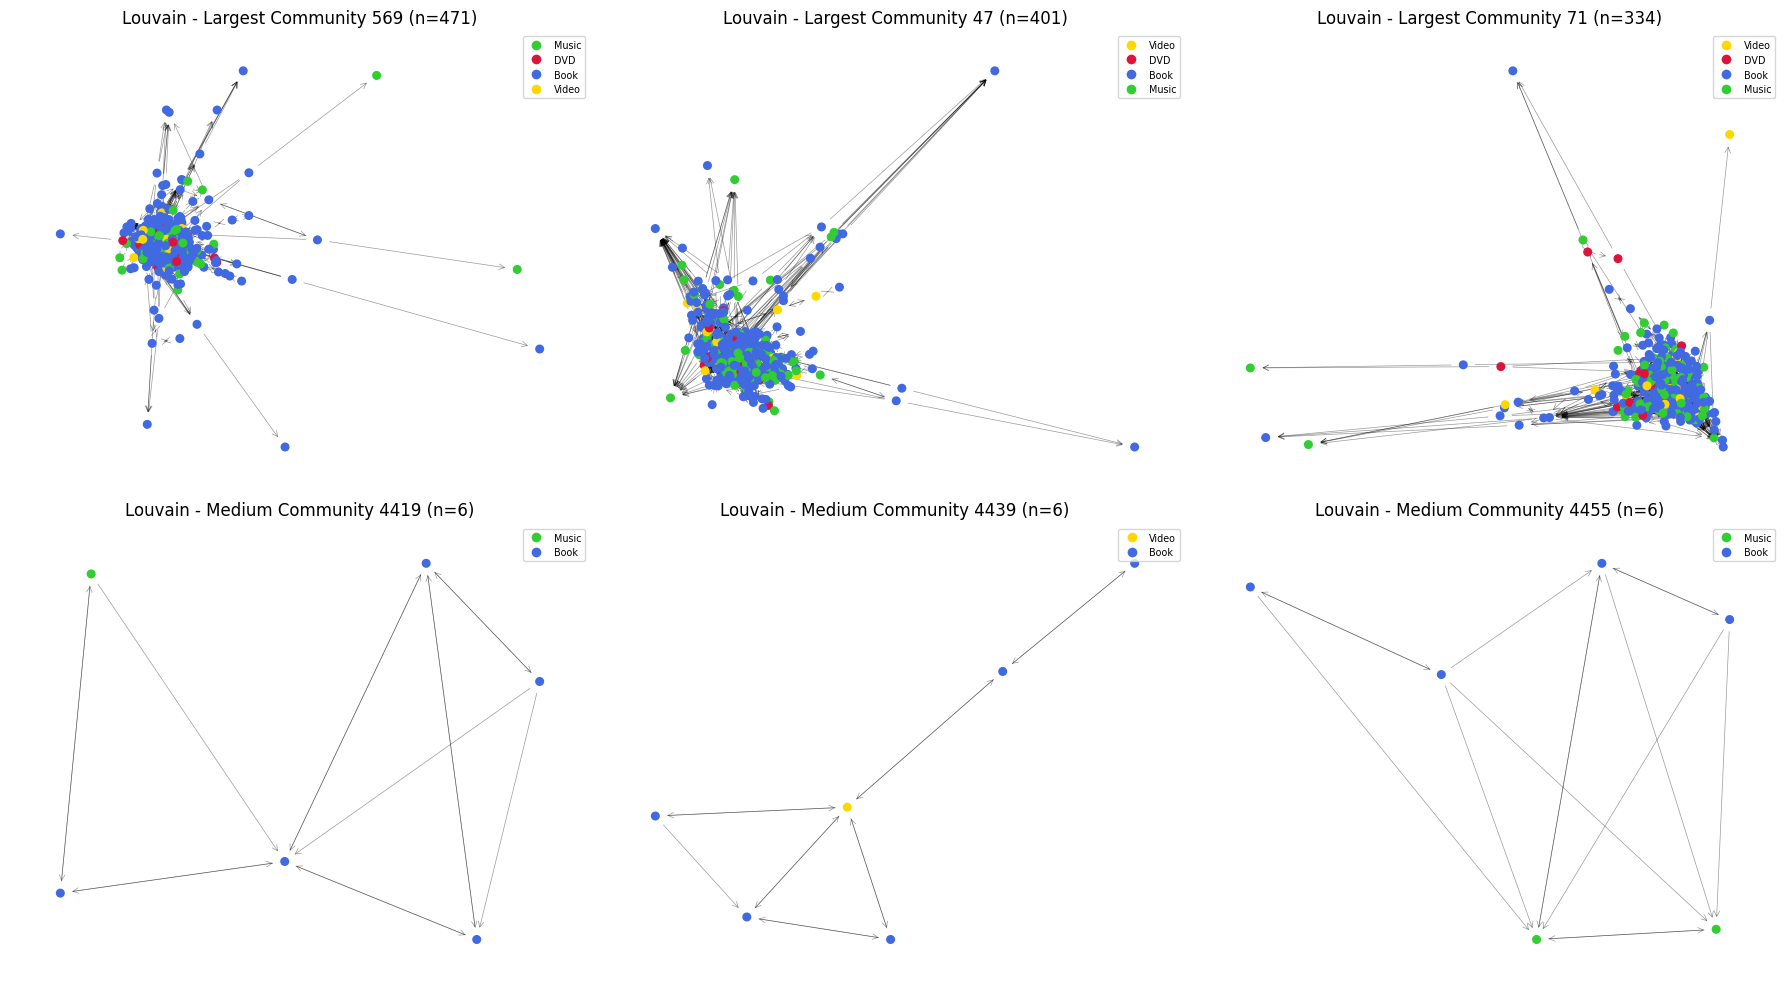

In [113]:
visualize_community_sample(G, lpa_communities, "LPA", max_nodes=500)